# Benchmark Testing MySQL vs. PostgreSQL (local and GCP instances)
#### by Jon Sax 
#### 12 January 2024

In [1]:
import pandas as pd
import timeit
import psycopg2
import string
from sqlalchemy import create_engine
import mysql.connector 
import pymysql
import matplotlib.pyplot as plt

# Creating the PostgreSQL local database connection

In [16]:
dbname = 'postgres'
user = 'postgres'
password = ''
host = 'localhost'
port = '5432'

In [17]:
# Connect to your PostgreSQL local

conn1 = psycopg2.connect(dbname = dbname, user = user, password = password, host = host, port = port)
cur = conn1.cursor()

In [18]:
conn1

<connection object at 0x7f8c25d0a430; dsn: 'user=postgres password=xxx dbname=postgres host=localhost port=5432', closed: 0>

In [19]:
## Which top 10 cities has ANNA played the most?

ANNAquery = """
    SELECT
        v.city,
        COUNT(DISTINCT e.eventID) AS eventCount
    FROM
        booking.venues v
    JOIN
        booking.events e ON v.venueID = e.venueID
    JOIN
        booking.artists a ON e.artistID = a.artistID
    WHERE
        a.artistname = 'ANNA'
    GROUP BY
        v.city
    ORDER BY
        eventCount DESC
    LIMIT 10;
"""

In [20]:
ANNAquery_df = pd.read_sql_query(ANNAquery, conn1)
ANNAquery_df

<ipython-input-20-e80d04a15b66>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ANNAquery_df = pd.read_sql_query(ANNAquery, conn1)


,city,eventcount
0,Miami,12
1,Brooklyn,8
2,San Diego,7
3,San Francisco,7
4,Montreal,6
5,Los Angeles,5
6,Chicago,5
7,Detroit,4
8,Dallas,4
9,Las Vegas,4


# Creating the MySQL local database connection

In [21]:
database2 = ''
user2 = 'root'
password2 = 'd@tascience'
host2 = 'localhost'

In [22]:
# Connect to MySQL local

conn2 = pymysql.connect(database = database2, user = user2, password = password2, host = host2)


In [23]:
## Which top 10 cities has ANNA played the most?

ANNAquery2 = """
    SELECT
        v.city,
        COUNT(DISTINCT e.eventID) AS eventCount
    FROM
        localmachinebookings.venues v
    JOIN
        localmachinebookings.events e ON v.venueID = e.venueID
    JOIN
        localmachinebookings.artists a ON e.artistID = a.artistID
    WHERE
        a.artistname = 'ANNA'
    GROUP BY
        v.city
    ORDER BY
        eventCount DESC
    LIMIT 10;
"""

In [24]:
ANNAquery_df2 = pd.read_sql_query(ANNAquery2, conn2)
ANNAquery_df2

<ipython-input-24-c2e8b9e72104>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ANNAquery_df2 = pd.read_sql_query(ANNAquery2, conn2)


,city,eventCount
0,Miami,12
1,Brooklyn,8
2,San Francisco,7
3,San Diego,7
4,Montreal,6
5,Chicago,5
6,Los Angeles,5
7,Las Vegas,4
8,Dallas,4
9,Washington DC,4


# Benchmark Testing MySQL vs. PostgreSQL Local Query Speeds

First, we will run this query 10 times in each local environment.

In [25]:
# Database connection parameters LOCAL
postgres_params_local = {
    "dbname": "postgres",
    "user": "postgres",
    "password": "",
    "host": "localhost",
    "port": "5432",
}

mysql_params_local = {
    "host": "localhost",
    "user": "root",
    "password": "d@tascience",
    "database": "",
}

In [26]:
# Database connection parameters CLOUD

mysql_params_cloud = {
    'user': 'root',
    'password': 'd@tascience',
    'host': '34.94.26.242',
    'database': 'bookings',
}

postgres_params_cloud = {
    'user': 'postgres',
    'password': 'allout88',
    'host': '35.233.165.53',
    'dbname': 'postgres',
}


### Testing performance on the first, less-complicated query

In [27]:
# Number of times to run the query
num_iterations = 10

# Function to run the query and measure execution time
def run_query_and_measure_time(connection_params, query):
    conn = None
    try:
        if "dbname" in connection_params:
            conn = psycopg2.connect(**connection_params)
        else:
            conn = pymysql.connect(**connection_params)

        # Measure the execution time using timeit
        execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)

        return execution_time

    finally:
        if conn:
            conn.close()

In [28]:
# Run the query for PostgreSQL
postgres_times = [run_query_and_measure_time(postgres_params_local, ANNAquery) for _ in range(num_iterations)]

# Run the query for MySQL
mysql_times = [run_query_and_measure_time(mysql_params_local, ANNAquery2) for _ in range(num_iterations)]

# Create a Pandas DataFrame with the results
data = {"PostgreSQL Local Small": postgres_times, "MySQL Local Small": mysql_times}
results_df = pd.DataFrame(data)

# Display the DataFrame
results_df


<ipython-input-27-e3825c878300>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,PostgreSQL Local Small,MySQL Local Small
0,0.004575,0.003400
1,0.004448,0.003181
2,0.004399,0.002787
3,0.004073,0.002908
4,0.004814,0.002848
5,0.004379,0.003271
6,0.005433,0.002783
7,0.004271,0.003494
8,0.003826,0.003255
9,0.003612,0.002765


Now, let's run the same query 100 times in both MySQL and PostgreSQL, and display the average execution time of each in a Pandas DataFrame.

In [29]:
# Number of times to run the query
num_iterations2 = 1000

# Function to run the query and measure time
def run_query_and_measure_time(connection_params, query):
    conn = None
    try:
        if "dbname" in connection_params:
            conn = psycopg2.connect(**connection_params)
        else:
            conn = pymysql.connect(**connection_params)

        # Measure the execution time using timeit
        execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)

        return execution_time

    finally:
        if conn:
            conn.close()

# Run the test for PostgreSQL
postgres_times = [run_query_and_measure_time(postgres_params_local, ANNAquery) for _ in range(num_iterations2)]

# Run the test for MySQL
mysql_times = [run_query_and_measure_time(mysql_params_local, ANNAquery2) for _ in range(num_iterations2)]

# Calculate the average time for each query
avg_postgres_time = sum(postgres_times) / num_iterations2
avg_mysql_time = sum(mysql_times) / num_iterations2

# Create a Pandas DataFrame with the results
data = {"Avg. PostgreSQL Local": avg_postgres_time, "Avg. MySQL Local": avg_mysql_time}
results_df2 = pd.DataFrame(data, index=["Average Time"])

# Display the DataFrame
results_df2

<ipython-input-29-935bc0adfbb2>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,Avg. PostgreSQL Local,Avg. MySQL Local
Average Time,0.004052,0.002935


### Testing performance on the second, complex query

In [30]:
superquery_mysql = """
WITH RankedEventPromoter AS (
    SELECT
        p.promoterid,
        p.promotername,
        COUNT(e.eventid) AS event_count,
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) AS distance_from_dc,
        v.latitude AS most_frequent_latitude,
        v.longitude AS most_frequent_longitude,
        v.city AS most_frequent_city,
        ROW_NUMBER() OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS row_num
    FROM
        bookschema.promoters p
    JOIN
        bookschema.events e ON p.promoterid = e.promoterid
    JOIN
        bookschema.artists a ON e.artistid = a.artistid
    JOIN
        bookschema.venues v ON e.venueid = v.venueid
    WHERE
        (a.artistgenre1 = 'Melodic House & Techno'
        OR a.artistgenre2 = 'Melodic House & Techno'
        OR a.artistgenre3 = 'Melodic House & Techno')
        AND p.active = true
    GROUP BY
        p.promoterid, v.latitude, v.longitude, v.city
    HAVING
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) <= 600
)

SELECT
    promotername,
    event_count,
    RANK() OVER (ORDER BY event_count DESC) AS ranking,
    distance_from_dc,
    most_frequent_latitude,
    most_frequent_longitude,
    most_frequent_city
FROM
    RankedEventPromoter
WHERE
    row_num = 1
ORDER BY
    ranking;
"""

In [31]:
superdf_mysql = pd.read_sql_query(superquery_mysql, conn2)
superdf_mysql.head(10)

<ipython-input-31-edb799af4b18>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  superdf_mysql = pd.read_sql_query(superquery_mysql, conn2)


,promotername,event_count,ranking,distance_from_dc,most_frequent_latitude,most_frequent_longitude,most_frequent_city
0,Avant Gardner,27,1,203.983281,40.652601,-73.949721,Brooklyn
1,Auris Presents,24,2,593.604470,41.875562,-87.624421,Chicago
2,Flash,18,3,0.008837,38.895037,-77.036543,Washington DC
3,Stereo,10,4,489.743629,45.503182,-73.569807,Montreal
4,Teksupport,8,5,203.983281,40.652601,-73.949721,Brooklyn
5,Real Talent Management,7,6,394.309044,42.360253,-71.058291,Boston
6,Paxahau,7,6,394.506883,42.331551,-83.046640,Detroit
7,Neon,7,6,489.743629,45.503182,-73.569807,Montreal
8,Repeat and Rinse,6,9,203.983281,40.652601,-73.949721,Brooklyn
9,Elysium Affairs,6,9,0.008837,38.895037,-77.036543,Washington DC


In [39]:
superquery_postgresql = """
WITH EventPromoterRanking AS (
    SELECT DISTINCT ON (p.promoterid)
        p.promoterid,
        p.promotername,
        COUNT(e.eventid) AS event_count,
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) AS distance_from_dc,
        FIRST_VALUE(v.latitude) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_latitude,
        FIRST_VALUE(v.longitude) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_longitude,
        FIRST_VALUE(v.city) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_city
    FROM
        booking.promoters p
    JOIN
        booking.events e ON p.promoterid = e.promoterid
    JOIN
        booking.artists a ON e.artistid = a.artistid
    JOIN
        booking.venues v ON e.venueid = v.venueid
    WHERE
        (a.artistgenre1 = 'Melodic House & Techno'
        OR a.artistgenre2 = 'Melodic House & Techno'
        OR a.artistgenre3 = 'Melodic House & Techno')
        AND p.active = true
    GROUP BY
        p.promoterid, v.latitude, v.longitude, v.city
    HAVING
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) <= 600
)

SELECT
    promotername,
    event_count,
    RANK() OVER (ORDER BY event_count DESC) AS ranking,
    distance_from_dc,
    most_frequent_latitude,
    most_frequent_longitude,
    most_frequent_city
FROM
    EventPromoterRanking
ORDER BY
    ranking;
"""

In [40]:
superdf_postgresql = pd.read_sql_query(superquery_postgresql, conn1)
superdf_postgresql.head(10)

<ipython-input-40-07b9480a779c>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  superdf_postgresql = pd.read_sql_query(superquery_postgresql, conn1)


,promotername,event_count,ranking,distance_from_dc,most_frequent_latitude,most_frequent_longitude,most_frequent_city
0,Avant Gardner,27,1,203.983281,40.652601,-73.949721,Brooklyn
1,Auris Presents,24,2,593.604470,41.875562,-87.624421,Chicago
2,Flash,18,3,0.008837,38.895037,-77.036543,Washington DC
3,Stereo,10,4,489.743629,45.503182,-73.569807,Montreal
4,Teksupport,8,5,203.983281,40.652601,-73.949721,Brooklyn
5,Real Talent Management,7,6,394.309044,42.360253,-71.058291,Boston
6,Paxahau,7,6,394.506883,42.331551,-83.046640,Detroit
7,Neon,7,6,489.743629,45.503182,-73.569807,Montreal
8,Elysium Affairs,6,9,0.008837,38.895037,-77.036543,Washington DC
9,Repeat and Rinse,6,9,203.983281,40.652601,-73.949721,Brooklyn


In [41]:
# The PostgreSQL query object is called superquery_postgresql
# The MySQL query object is called superquery_mysql

# Run the query for PostgreSQL
postgres_times_local = [run_query_and_measure_time(postgres_params_local, superquery_postgresql) for _ in range(num_iterations)]

# Run the query for MySQL
mysql_times_local = [run_query_and_measure_time(mysql_params_local, superquery_mysql) for _ in range(num_iterations)]

# Create a Pandas DataFrame with the results
data = {"PostgreSQL Local": postgres_times_local, "MySQL Local": mysql_times_local}
results_df = pd.DataFrame(data)

# Display the DataFrame
results_df


<ipython-input-29-935bc0adfbb2>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,PostgreSQL Local,MySQL Local
0,0.008662,0.008931
1,0.006892,0.008793
2,0.006875,0.009059
3,0.006678,0.009013
4,0.006939,0.009131
5,0.006705,0.009054
6,0.006769,0.009144
7,0.006937,0.009128
8,0.006815,0.008920
9,0.006717,0.010384


In [42]:
# Number of times to run the query
num_iterations2 = 1000

# Function to run the query and measure time
def run_query_and_measure_time(connection_params, query):
    conn = None
    try:
        if "dbname" in connection_params:
            conn = psycopg2.connect(**connection_params)
        else:
            conn = pymysql.connect(**connection_params)

        # Measure the execution time using timeit
        execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)

        return execution_time

    finally:
        if conn:
            conn.close()

# Run the test for PostgreSQL
postgres_times_local = [run_query_and_measure_time(postgres_params_local, superquery_postgresql) for _ in range(num_iterations2)]

# Run the test for MySQL
mysql_times_local = [run_query_and_measure_time(mysql_params_local, superquery_mysql) for _ in range(num_iterations2)]

# Calculate the average time for each query
avg_postgres_time = sum(postgres_times_local) / num_iterations2
avg_mysql_time = sum(mysql_times_local) / num_iterations2

# Create a Pandas DataFrame with the results
data = {"Avg. PostgreSQL Local": avg_postgres_time, "Avg. MySQL Local": avg_mysql_time}
results_df3 = pd.DataFrame(data, index=["Average Time"])

# Display the DataFrame
results_df3

<ipython-input-42-49c2162db25a>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,Avg. PostgreSQL Local,Avg. MySQL Local
Average Time,0.007886,0.009282


Postgres Local performed better with the small query. PostgreSQL local also performed better with the large query.

# Creating the postgreSQL Google Cloud database connection

In [43]:
# Connect to your PostgreSQL database in Google Cloud

conn3 = psycopg2.connect(
    host="35.233.165.53",
    database="postgres",
    user="postgres",
    password="allout88")

In [44]:
conn3

<connection object at 0x7f8c25d0a970; dsn: 'user=postgres password=xxx dbname=postgres host=35.233.165.53', closed: 0>

In [45]:
superqueryPGcloud = """
WITH EventPromoterRanking AS (
    SELECT DISTINCT ON (p.promoterid)
        p.promoterid,
        p.promotername,
        COUNT(e.eventid) AS event_count,
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) AS distance_from_dc,
        FIRST_VALUE(v.latitude) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_latitude,
        FIRST_VALUE(v.longitude) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_longitude,
        FIRST_VALUE(v.city) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_city
    FROM
        bookschema.promoters p
    JOIN
        bookschema.events e ON p.promoterid = e.promoterid
    JOIN
        bookschema.artists a ON e.artistid = a.artistid
    JOIN
        bookschema.venues v ON e.venueid = v.venueid
    WHERE
        (a.artistgenre1 = 'Melodic House & Techno'
        OR a.artistgenre2 = 'Melodic House & Techno'
        OR a.artistgenre3 = 'Melodic House & Techno')
        AND p.active = true
    GROUP BY
        p.promoterid, v.latitude, v.longitude, v.city
    HAVING
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) <= 600
)

SELECT
    promotername,
    event_count,
    RANK() OVER (ORDER BY event_count DESC) AS ranking,
    distance_from_dc,
    most_frequent_latitude,
    most_frequent_longitude,
    most_frequent_city
FROM
    EventPromoterRanking
ORDER BY
    ranking;
"""

In [46]:
superdf_postgresql = pd.read_sql_query(superqueryPGcloud, conn3)
superdf_postgresql.head(10)

<ipython-input-46-23c76c0593a6>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  superdf_postgresql = pd.read_sql_query(superqueryPGcloud, conn3)


,promotername,event_count,ranking,distance_from_dc,most_frequent_latitude,most_frequent_longitude,most_frequent_city
0,Avant Gardner,27,1,203.983281,40.652601,-73.949721,Brooklyn
1,Auris Presents,24,2,593.604470,41.875562,-87.624421,Chicago
2,Flash,18,3,0.008837,38.895037,-77.036543,Washington DC
3,Stereo,10,4,489.743629,45.503182,-73.569807,Montreal
4,Teksupport,8,5,203.983281,40.652601,-73.949721,Brooklyn
5,Real Talent Management,7,6,394.309044,42.360253,-71.058291,Boston
6,Paxahau,7,6,394.506883,42.331551,-83.046640,Detroit
7,Neon,7,6,489.743629,45.503182,-73.569807,Montreal
8,Elysium Affairs,6,9,0.008837,38.895037,-77.036543,Washington DC
9,Repeat and Rinse,6,9,203.983281,40.652601,-73.949721,Brooklyn


# Creating the MySQL Google Cloud database connection

In [47]:
# Connect to your MySQL database in Google Cloud

mysql_params_cloud = {
    'user': 'root',
    'password': 'd@tascience',
    'host': '34.94.26.242',
    'database': 'bookings',
}

# Establish a connection
conn4 = mysql.connector.connect(**mysql_params_cloud)

In [48]:
conn4

In [49]:
# Create a cursor
cursor = conn4.cursor()

# Example: Execute a query - MYSQL IS CASE SENSITIVE
cursor.execute("SELECT * FROM bookings.artists")

# Fetch the results
results = cursor.fetchall()

# Print the results
for row in results:
    print(row)

(1, '8Kays', 'Melodic House & Techno', 'Indie Dance', 'Progressive House')
(2, 'Adana Twins', 'Melodic House & Techno', 'Indie Dance', 'Electronica')
(3, 'andhim', 'House', 'Melodic House & Techno', 'Indie Dance')
(4, 'Anja Schneider', 'Melodic House & Techno', 'House', 'Techno (Raw / Deep / Hypnotic)')
(5, 'ANNA', 'Techno (Peak Time / Driving)', 'Techno (Raw / Deep / Hypnotic)', 'Electronica')
(6, 'Archie Hamilton', 'Minimal / Deep Tech', 'Tech House', 'House')
(7, 'Ardalan', 'Tech House', 'Deep House', 'Electro (Classic / Detroit / Modern)')
(8, 'BEC', 'Techno (Peak Time / Driving)', 'Breaks / Breakbeat / UK Bass', 'Techno (Raw / Deep / Hypnotic)')
(9, 'Billy Kenny', 'Tech House', 'Deep House', 'House')
(10, 'Booka Shade', 'Melodic House & Techno', 'Deep House', 'Electronica')
(11, 'Butch', 'Tech House', 'Deep House', 'Techno (Peak Time / Driving)')
(12, 'Charlotte de Witte', 'Techno (Peak Time / Driving)', 'Hard Techno', 'Techno (Raw / Deep / Hypnotic)')
(13, 'Christian Martin', 'Te

In [50]:
superquery_mysql_cloud = """
WITH RankedEventPromoter AS (
    SELECT
        p.promoterid,
        p.promotername,
        COUNT(e.eventid) AS event_count,
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) AS distance_from_dc,
        v.latitude AS most_frequent_latitude,
        v.longitude AS most_frequent_longitude,
        v.city AS most_frequent_city,
        ROW_NUMBER() OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS row_num
    FROM
        booking.promoters p
    JOIN
        booking.events e ON p.promoterid = e.promoterid
    JOIN
        booking.artists a ON e.artistid = a.artistid
    JOIN
        booking.venues v ON e.venueid = v.venueid
    WHERE
        (a.artistgenre1 = 'Melodic House & Techno'
        OR a.artistgenre2 = 'Melodic House & Techno'
        OR a.artistgenre3 = 'Melodic House & Techno')
        AND p.active = true
    GROUP BY
        p.promoterid, v.latitude, v.longitude, v.city
    HAVING
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(38.8951)) * COS(RADIANS(v.longitude) - RADIANS(-77.0364))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(38.8951))
            )
        ) <= 600
)

SELECT
    promotername,
    event_count,
    RANK() OVER (ORDER BY event_count DESC) AS ranking,
    distance_from_dc,
    most_frequent_latitude,
    most_frequent_longitude,
    most_frequent_city
FROM
    RankedEventPromoter
WHERE
    row_num = 1
ORDER BY
    ranking;
"""

In [51]:
superdf_mysql_cloud = pd.read_sql_query(superquery_mysql_cloud, conn4)
superdf_mysql_cloud.head(10)

<ipython-input-51-5d1164928d33>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  superdf_mysql_cloud = pd.read_sql_query(superquery_mysql_cloud, conn4)


,promotername,event_count,ranking,distance_from_dc,most_frequent_latitude,most_frequent_longitude,most_frequent_city
0,Avant Gardner,27,1,203.983281,40.652601,-73.949721,Brooklyn
1,Auris Presents,24,2,593.604470,41.875562,-87.624421,Chicago
2,Flash,18,3,0.008837,38.895037,-77.036543,Washington DC
3,Stereo,10,4,489.743629,45.503182,-73.569807,Montreal
4,Teksupport,8,5,203.983281,40.652601,-73.949721,Brooklyn
5,Real Talent Management,7,6,394.309044,42.360253,-71.058291,Boston
6,Paxahau,7,6,394.506883,42.331551,-83.046640,Detroit
7,Neon,7,6,489.743629,45.503182,-73.569807,Montreal
8,Repeat and Rinse,6,9,203.983281,40.652601,-73.949721,Brooklyn
9,Elysium Affairs,6,9,0.008837,38.895037,-77.036543,Washington DC


Small query in the cloud databases:

In [52]:
## PostgreSQL Cloud - Which top 10 cities has ANNA played the most? 

ANNAquerypostgrescloud = """
    SELECT
        v.city,
        COUNT(DISTINCT e.eventID) AS eventCount
    FROM
        venues v
    JOIN
        events e ON v.venueID = e.venueID
    JOIN
        artists a ON e.artistID = a.artistID
    WHERE
        a.artistname = 'ANNA'
    GROUP BY
        v.city
    ORDER BY
        eventCount DESC
    LIMIT 10;
"""

In [53]:
## MySQL Cloud - Which top 10 cities has ANNA played the most? 

ANNAquerymysqlcloud = """
    SELECT
        v.city,
        COUNT(DISTINCT e.eventID) AS eventCount
    FROM
        bookings.venues v
    JOIN
        bookings.events e ON v.venueID = e.venueID
    JOIN
        bookings.artists a ON e.artistID = a.artistID
    WHERE
        a.artistname = 'ANNA'
    GROUP BY
        v.city
    ORDER BY
        eventCount DESC
    LIMIT 10;
"""

In [54]:
# The PostgreSQL query object is called superquery_postgresql
# The MySQL query object is called superquery_mysql

# Run the query for PostgreSQL
postgres_times_small = [run_query_and_measure_time(postgres_params_cloud, ANNAquerypostgrescloud) for _ in range(num_iterations)]

# Run the query for MySQL
mysql_times_small = [run_query_and_measure_time(mysql_params_cloud, ANNAquerymysqlcloud) for _ in range(num_iterations)]

# Create a Pandas DataFrame with the results
data2 = {"PostgreSQL Cloud Small": postgres_times_small, "MySQL Cloud Small": mysql_times_small}
results_df4 = pd.DataFrame(data2)

# Display the DataFrame
results_df4

<ipython-input-42-49c2162db25a>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,PostgreSQL Cloud Small,MySQL Cloud Small
0,0.070279,0.019135
1,0.069257,0.016254
2,0.075799,0.017526
3,0.064384,0.017649
4,0.070488,0.018878
5,0.068954,0.017208
6,0.068999,0.016384
7,0.078068,0.017210
8,0.075763,0.016101
9,0.079374,0.018125


In [55]:
avgpostgrescloudsmall = results_df4['PostgreSQL Cloud Small'].mean()
avgmysqlcloudsmall = results_df4['MySQL Cloud Small'].mean()

avgpostgrescloudsmall

0.07213660740003433

In [56]:
avgmysqlcloudsmall

0.017447014599974865

MySQL cloud performed better with the small query. 

# Benchmark testing all four databases' superquery times (100 times)

In [58]:
# Function to run the query and measure time
def run_query_and_measure_time(connection_params, query):
    conn = None
    try:
        if "dbname" in connection_params:
            conn = psycopg2.connect(**connection_params)
        else:
            conn = pymysql.connect(**connection_params)

        # Measure the execution time using timeit
        execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)

        return execution_time

    finally:
        if conn:
            conn.close()

# Run the test for PostgreSQL
postgres_times = [run_query_and_measure_time(postgres_params_cloud, superqueryPGcloud) for _ in range(num_iterations2)]

# Run the test for MySQL
mysql_times = [run_query_and_measure_time(mysql_params_cloud, superquery_mysql_cloud) for _ in range(num_iterations2)]

# Calculate the average time for each query
avg_postgres_time = sum(postgres_times) / num_iterations2
avg_mysql_time = sum(mysql_times) / num_iterations2

# Create a Pandas DataFrame with the results
data = {"Avg. PostgreSQL Cloud": avg_postgres_time, "Avg. MySQL Cloud": avg_mysql_time}
results_df5 = pd.DataFrame(data, index=["Average Time"])

results_df5

<ipython-input-58-b3201e399067>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,Avg. PostgreSQL Cloud,Avg. MySQL Cloud
Average Time,0.078489,0.030139


In [59]:
results_df3

,Avg. PostgreSQL Local,Avg. MySQL Local
Average Time,0.007886,0.009282


MySQL cloud performed better with the large query.

### Histograms of all four databases' performances on the superquery (100 iterations)

In [60]:
# The PostgreSQL local AND cloud superquery object is called superquery_postgresql
# The MySQL local query object is called superquery_mysql_local
# The MySQL cloud query object is called superquery_mysql_cloud

# Run the query for PostgreSQL local
postgres_times_local = [run_query_and_measure_time(postgres_params_local, superquery_postgresql) for _ in range(num_iterations2)]

# Run the query for MySQL local
mysql_times_local = [run_query_and_measure_time(mysql_params_local, superquery_mysql) for _ in range(num_iterations2)]

# Create a Pandas DataFrame with the results
data_for_postgreslocalhist = {"PostgreSQL Local": postgres_times_local}
df_for_postgreslocalhist = pd.DataFrame(data_for_postgreslocalhist)

# Display the DataFrame
df_for_postgreslocalhist


<ipython-input-58-b3201e399067>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,PostgreSQL Local
0,0.007585
1,0.007455
2,0.006789
3,0.007504
4,0.007668
...,...
95,0.009045
96,0.007687
97,0.007907
98,0.007344


In [61]:
# Multiply by 100
df_for_postgreslocalhist['PostgreSQL Local'] = df_for_postgreslocalhist['PostgreSQL Local']*100
df_for_postgreslocalhist

,PostgreSQL Local
0,0.758477
1,0.745523
2,0.678913
3,0.750397
4,0.766760
...,...
95,0.904473
96,0.768699
97,0.790747
98,0.734415


In [62]:
average_value_pglocal = df_for_postgreslocalhist['PostgreSQL Local'].mean()

print("Average:", average_value_pglocal)

Average: 0.7951209299985749


In [82]:
std_deviation_pglocal = df_for_postgreslocalhist['PostgreSQL Local'].std()
std_deviation_pglocal

0.09014882580013953

In [63]:
# Run the query for MySQL local
mysql_times_local = [run_query_and_measure_time(mysql_params_local, superquery_mysql) for _ in range(num_iterations2)]

# Create a Pandas DataFrame with the results
data_for_mysqllocalhist = {"MySQL Local": mysql_times_local}
df_for_mysqllocalhist = pd.DataFrame(data_for_mysqllocalhist)
df_for_mysqllocalhist

<ipython-input-58-b3201e399067>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,MySQL Local
0,0.011203
1,0.010559
2,0.011115
3,0.009983
4,0.011821
...,...
95,0.011867
96,0.009728
97,0.010001
98,0.009547


In [64]:
# Multiply by 100
df_for_mysqllocalhist['MySQL Local'] = df_for_mysqllocalhist['MySQL Local']*100
df_for_mysqllocalhist

,MySQL Local
0,1.120310
1,1.055909
2,1.111533
3,0.998325
4,1.182110
...,...
95,1.186686
96,0.972755
97,1.000089
98,0.954725


In [65]:
average_value_mslocal = df_for_mysqllocalhist['MySQL Local'].mean()

print("Average:", average_value_mslocal)

Average: 1.0059386699990682


In [83]:
std_deviation_mslocal = df_for_mysqllocalhist['MySQL Local'].std()
std_deviation_mslocal

0.0731390403073738

In [67]:
# Run the test for PostgreSQL cloud
postgres_times_cloud = [run_query_and_measure_time(postgres_params_cloud, superqueryPGcloud) for _ in range(num_iterations2)]

# Create a Pandas DataFrame with the results
data_for_postgresqlcloudhist = {"PostgreSQL Cloud": postgres_times_cloud}
df_for_postgrescloudhist = pd.DataFrame(data_for_postgresqlcloudhist)
df_for_postgrescloudhist


<ipython-input-58-b3201e399067>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,PostgreSQL Cloud
0,0.078921
1,0.079197
2,0.088587
3,0.088957
4,0.082653
...,...
95,0.078123
96,0.083730
97,0.079868
98,0.074780


In [68]:
# Multiply by 100
df_for_postgrescloudhist['PostgreSQL Cloud'] = df_for_postgrescloudhist['PostgreSQL Cloud']*100
df_for_postgrescloudhist

,PostgreSQL Cloud
0,7.892100
1,7.919693
2,8.858693
3,8.895729
4,8.265318
...,...
95,7.812338
96,8.372977
97,7.986840
98,7.478000


In [87]:
average_value_pgcloud = df_for_postgrescloudhist['PostgreSQL Cloud'].mean()

print("Average:", average_value_pgcloud)

Average: 8.068545821000953


In [89]:
std_deviation_pgcloud = df_for_postgrescloudhist['PostgreSQL Cloud'].std()
std_deviation_pgcloud

0.520356447763443

In [71]:
# Run the query for mySQL cloud
mysql_times_cloud = [run_query_and_measure_time(mysql_params_cloud, superquery_mysql_cloud) for _ in range(num_iterations2)]

# Create a Pandas DataFrame with the results
data_for_mysqlcloudhist = {"MySQL Cloud": mysql_times_cloud}
df_for_mysqlcloudhist = pd.DataFrame(data_for_mysqlcloudhist)
df_for_mysqlcloudhist

<ipython-input-58-b3201e399067>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  execution_time = timeit.timeit(lambda: pd.read_sql_query(query, conn), number=1)


,MySQL Cloud
0,0.028145
1,0.030030
2,0.027001
3,0.026394
4,0.033547
...,...
95,0.026399
96,0.027082
97,0.030579
98,0.029700


In [72]:
# Multiply by 100
df_for_mysqlcloudhist['MySQL Cloud'] = df_for_mysqlcloudhist['MySQL Cloud']*100
df_for_mysqlcloudhist

,MySQL Cloud
0,2.814502
1,3.003037
2,2.700056
3,2.639355
4,3.354676
...,...
95,2.639916
96,2.708220
97,3.057872
98,2.969970


In [73]:
average_for_mysqlcloudhist = df_for_mysqlcloudhist['MySQL Cloud'].mean()

print("Average:", average_for_mysqlcloudhist)

Average: 2.835275378998631


In [81]:
std_deviation_mscloud = df_for_mysqlcloudhist['MySQL Cloud'].std()
std_deviation_mscloud

0.26628086671577683

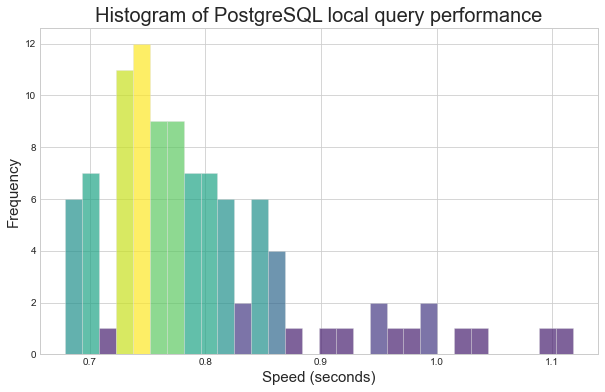

In [74]:
# postgreSQL local histogram

plt.figure(figsize=(10,6)) # Plot size
plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df_for_postgreslocalhist, bins=30, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer, otherwise it wouldn't work properly

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Adding title and labels with custom font sizes
plt.title('Histogram of PostgreSQL local query performance', fontsize=20)
plt.xlabel('Speed (seconds)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

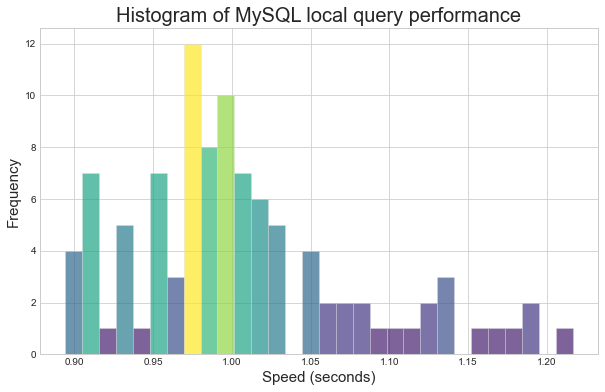

In [75]:
# MySQL local histogram

plt.figure(figsize=(10,6)) # Plot size
plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df_for_mysqllocalhist, bins=30, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer, otherwise it wouldn't work properly

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Adding title and labels with custom font sizes
plt.title('Histogram of MySQL local query performance', fontsize=20)
plt.xlabel('Speed (seconds)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

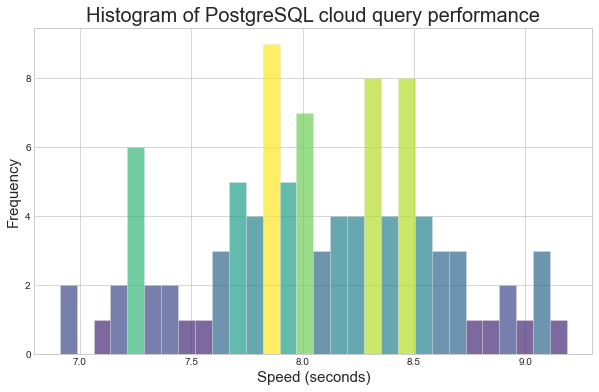

In [76]:
# postgreSQL cloud histogram

plt.figure(figsize=(10,6)) # Plot size
plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df_for_postgrescloudhist, bins=30, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer, otherwise it wouldn't work properly

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Adding title and labels with custom font sizes
plt.title('Histogram of PostgreSQL cloud query performance', fontsize=20)
plt.xlabel('Speed (seconds)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

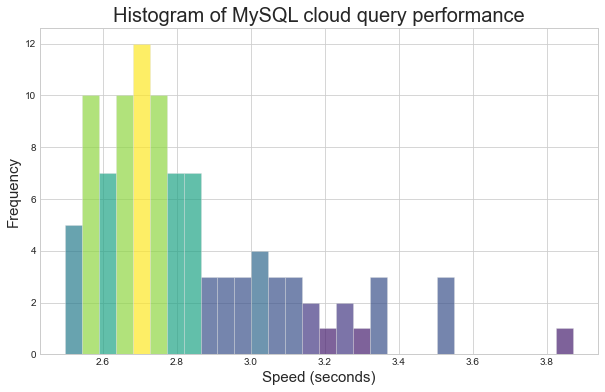

In [77]:
# MySQL cloud histogram

plt.figure(figsize=(10,6)) # Plot size
plt.style.use('seaborn-whitegrid') # Style

# Building a histogram
n, bins, patches = plt.hist(df_for_mysqlcloudhist, bins=30, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

# Changing properties of each bin
n = n.astype('int') # n should be integer, otherwise it wouldn't work properly

# Accessing each bin, changing color according to height
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Adding title and labels with custom font sizes
plt.title('Histogram of MySQL cloud query performance', fontsize=20)
plt.xlabel('Speed (seconds)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

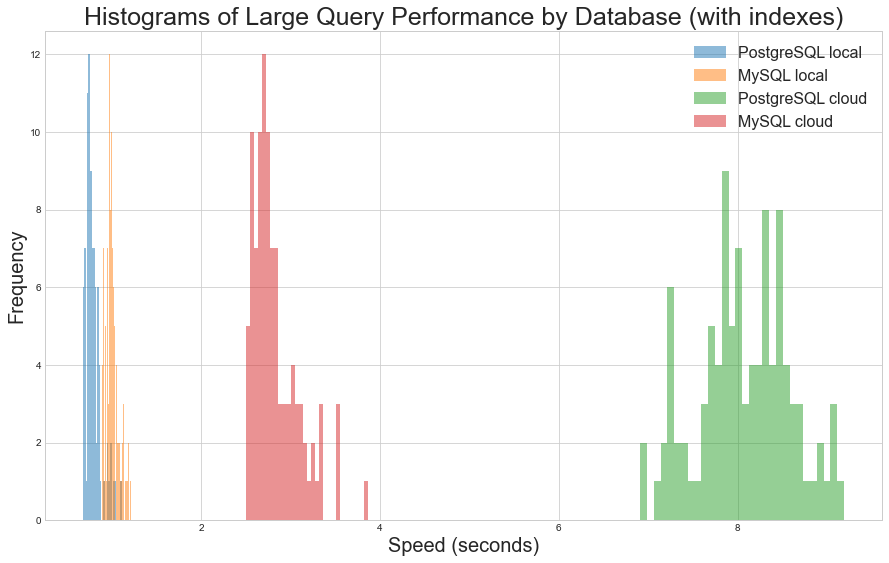

In [79]:
# Plot histograms
plt.figure(figsize=(15, 9))

plt.hist(df_for_postgreslocalhist, bins=30, alpha=0.5, label='PostgreSQL local')
plt.hist(df_for_mysqllocalhist, bins=30, alpha=0.5, label='MySQL local')
plt.hist(df_for_postgrescloudhist, bins=30, alpha=0.5, label='PostgreSQL cloud')
plt.hist(df_for_mysqlcloudhist, bins=30, alpha=0.5, label='MySQL cloud')

plt.title('Histograms of Large Query Performance by Database (with indexes)', fontsize=25)
plt.xlabel('Speed (seconds)', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(fontsize=16)

plt.show()